<a href="https://colab.research.google.com/github/natbugreal/datascience/blob/main/NataPereU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb

# MLB batting average w different predictors

My data set is an organization of stats by player. In this project I am aiming to determine the batting average of players using their other stats provided, this can be anything from off base Percentage to home run success. Similar to soccer or basketball -- skill is important for Batting average, high skills attract high stats so a good batting average is basically composed of a good everything else lol

In [1]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-sw09d4om
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-sw09d4om
  Resolved https://github.com/pydata/xarray.git to commit c25215299c02cd36781cf3aa38e8583d1fe14849
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev1+gc2521529-py3-none-any.whl size=1247984 sha256=2de9ff36e569f48f223fcbad6130d069f60d45c633a845a9c02d5bb71e94b00d
  Stored in directory: /tmp/pip-ephem-wheel-cache-c0szi02t/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 241.2 kB/s eta 0:00:00
   

In [87]:
baseball = pd.read_csv('https://raw.githubusercontent.com/benji555-create/Data-Science/refs/heads/main/Fixed%20data.csv', header=0)
baseball

k             Player   Age Team   Lg  WAR      G     PA     AB  \
0      1.0      Jarren Duran*  27.0  BOS   AL  8.7  160.0  735.0  671.0   
1      2.0     Shohei Ohtani*  29.0  LAD   NL  9.2  159.0  731.0  636.0   
2      3.0  Gunnar Henderson*  23.0  BAL   AL  9.1  159.0  719.0  630.0   
3      4.0      Marcus Semien  33.0  TEX   AL  4.1  159.0  718.0  650.0   
4      5.0         Juan Soto*  25.0  NYY   AL  7.9  157.0  713.0  576.0   
..     ...                ...   ...  ...  ...  ...    ...    ...    ...   
771  738.0    Josh Winckowski  26.0  BOS   AL  0.0    1.0    0.0    0.0   
772  739.0       Kirby Yates*  37.0  TEX   AL  0.0    3.0    0.0    0.0   
773  740.0        Alex Young*  30.0  CIN   NL  0.0    1.0    0.0    0.0   
774  741.0      Guillo Zuñiga  25.0  LAA   AL  0.0    1.0    0.0    0.0   
775    NaN        MLB Average   NaN  NaN  NaN  NaN    NaN    NaN    NaN   

         R  ...   OPS+   rOBA  Rbat+     TB  GIDP  HBP   SH   SF   IBB  Pos  
0    111.0  ...  129.0  0.373  134.0  330.0   6.0  6.0  1.0  3.0   1.0   OF  
1    134.0  ...  190.0  0.449  190.0  411.0   7.0  6.0  0.0  5.0  10.0   DH  
2    118.0  ...  159.0  0.385  157.0  333.0   2.0  7.0  0.0  4.0   1.0   SS  
3    101.0  ...  100.0  0.310  100.0  254.0   9.0  3.0  0.0  1.0   2.0   2B  
4    128.0  ...  178.0  0.424  179.0  328.0  10.0  4.0  0.0  4.0   2.0   OF  
..     ...  ...    ...    ...    ...    ...   ...  ...  ...  ...   ...  ...  
771    0.0  ...    NaN    NaN    NaN    0.0   0.0  0.0  0.0  0.0   0.0  NaN  
772    0.0  ...    NaN    NaN    NaN    0.0   0.0  0.0  0.0  0.0   0.0  NaN  
773    0.0  ...    NaN    NaN    NaN    0.0   0.0  0.0  0.0  0.0   0.0  NaN  
774    0.0  ...    NaN    NaN    NaN    0.0   0.0  0.0  0.0  0.0   0.0  NaN  
775    NaN  ...    NaN    NaN    NaN    NaN   NaN  NaN  NaN  NaN   NaN  NaN  

[776 rows x 33 columns]

I expected for this to refelct more information than i actually need, im going to modify it so that it only provides WAR, BA, OBP, HR and Position.


In [88]:
baseball = baseball.query('PA>200')
baseball = baseball[['Player', 'WAR', 'BA', 'OBP', 'HR', 'SLG', 'Pos']]
baseball

Player  WAR     BA    OBP    HR    SLG   Pos
0        Jarren Duran*  8.7  0.285  0.342  21.0  0.492    OF
1       Shohei Ohtani*  9.2  0.310  0.390  54.0  0.646    DH
2    Gunnar Henderson*  9.1  0.281  0.364  37.0  0.529    SS
3        Marcus Semien  4.1  0.237  0.308  23.0  0.391    2B
4           Juan Soto*  7.9  0.288  0.419  41.0  0.569    OF
..                 ...  ...    ...    ...   ...    ...   ...
360     Trent Grisham*  0.4  0.190  0.290   9.0  0.385    OF
361      Kyle Stowers* -0.5  0.208  0.268   3.0  0.333  UTIL
362  Jackson Holliday*  0.1  0.189  0.255   5.0  0.311    2B
363        Jorge Mateo  0.9  0.229  0.267   5.0  0.401    2B
364  Travis Jankowski*  0.3  0.200  0.266   1.0  0.242  UTIL

[365 rows x 7 columns]

Ill make a scatter plot to isolate BA in comparison to WAR. I believe there will be a linear positive trend.

<Axes: xlabel='WAR', ylabel='BA'>

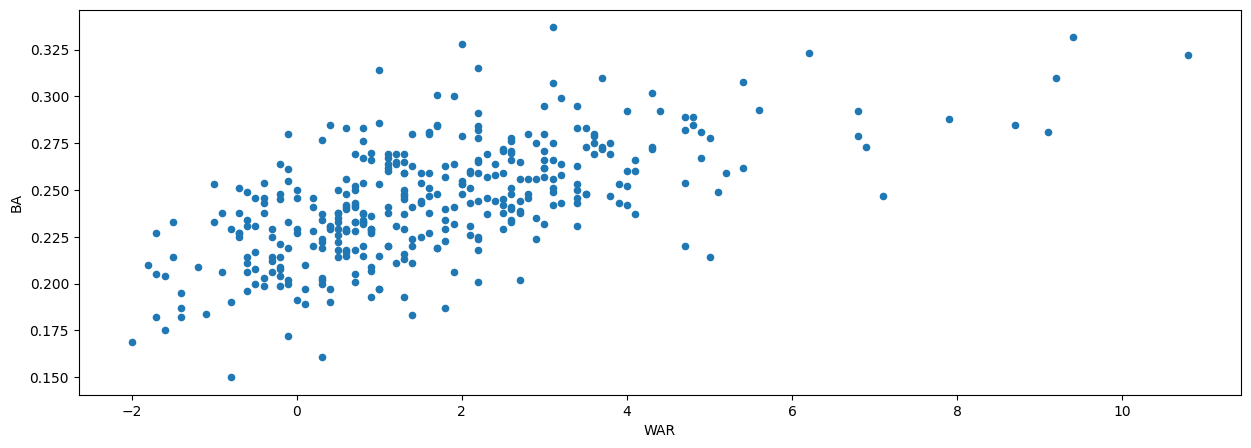

In [89]:
baseball.plot(x="WAR", y="BA", figsize=(15, 5), kind="scatter")

In [94]:
print(baseball)

                Player  WAR     BA    OBP    HR    SLG   Pos
0        Jarren Duran*  8.7  0.285  0.342  21.0  0.492    OF
1       Shohei Ohtani*  9.2  0.310  0.390  54.0  0.646    DH
2    Gunnar Henderson*  9.1  0.281  0.364  37.0  0.529    SS
3        Marcus Semien  4.1  0.237  0.308  23.0  0.391    2B
4           Juan Soto*  7.9  0.288  0.419  41.0  0.569    OF
..                 ...  ...    ...    ...   ...    ...   ...
360     Trent Grisham*  0.4  0.190  0.290   9.0  0.385    OF
361      Kyle Stowers* -0.5  0.208  0.268   3.0  0.333  UTIL
362  Jackson Holliday*  0.1  0.189  0.255   5.0  0.311    2B
363        Jorge Mateo  0.9  0.229  0.267   5.0  0.401    2B
364  Travis Jankowski*  0.3  0.200  0.266   1.0  0.242  UTIL

[365 rows x 7 columns]


Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


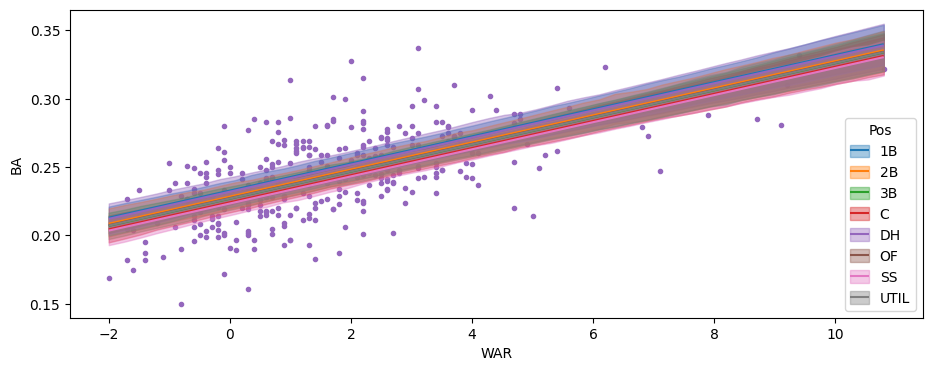

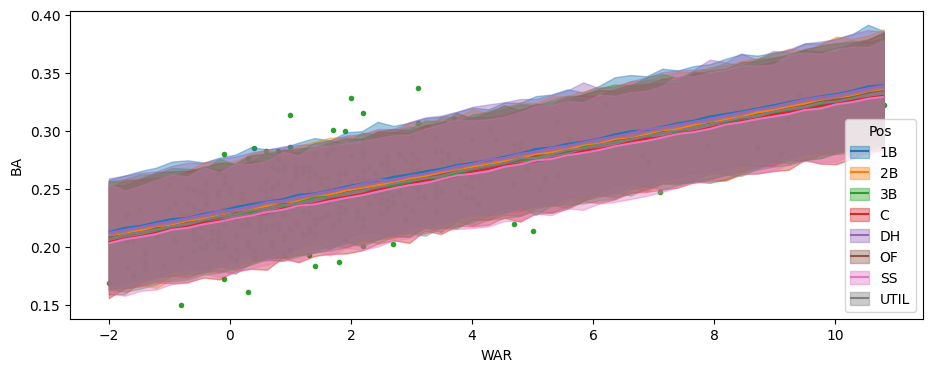

In [114]:
#define the model
model_baseball1 = bmb.Model("BA ~ Pos + WAR", data=baseball)
#fit the model
idata_model_baseball1 = model_baseball.fit(idata_kwargs={'log_likelihood': True})
#checking priors
model_baseball
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["WAR", "Pos"], fig_kwargs={"figsize":(11, 4)})
plt.plot(baseball.WAR, baseball.BA, "C14.", zorder=-3)

bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["WAR", "Pos"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(baseball.WAR, baseball.BA, "C2.", zorder=-3)

ok wooooo. I think the model does an alright job, there are a few outsliers that the lines do not cover, but to be honest, the positioning is not the best since baseball doesnt really use postiion the same way that other sports do. im going to do the same ting except trade out WAR with HR

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


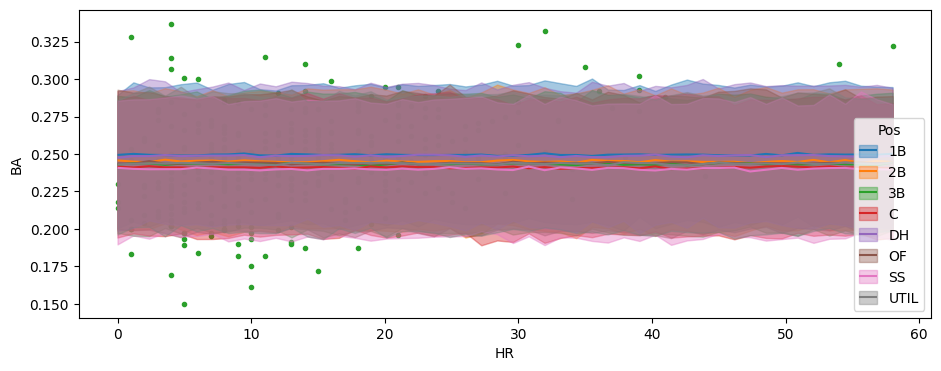

In [115]:
#define the model
model_baseball2= bmb.Model("BA ~ HR + Pos", data=baseball)
#fit the model
idata_model_baseball2 = model_baseball.fit(idata_kwargs={'log_likelihood': True})
#checking priors
model_baseball
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["HR", "Pos"], fig_kwargs={"figsize":(11, 4)})
plt.plot(baseball.HR, baseball.BA, "C14.", zorder=-3)

bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["HR", "Pos"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(baseball.HR, baseball.BA, "C2.", zorder=-3)

It seems to do a good job at following the data. im going to use the same code, but instead of position ill introduce player, to see how war and ba differ between individual players, hopefully the player will align with its own BA and WAR

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


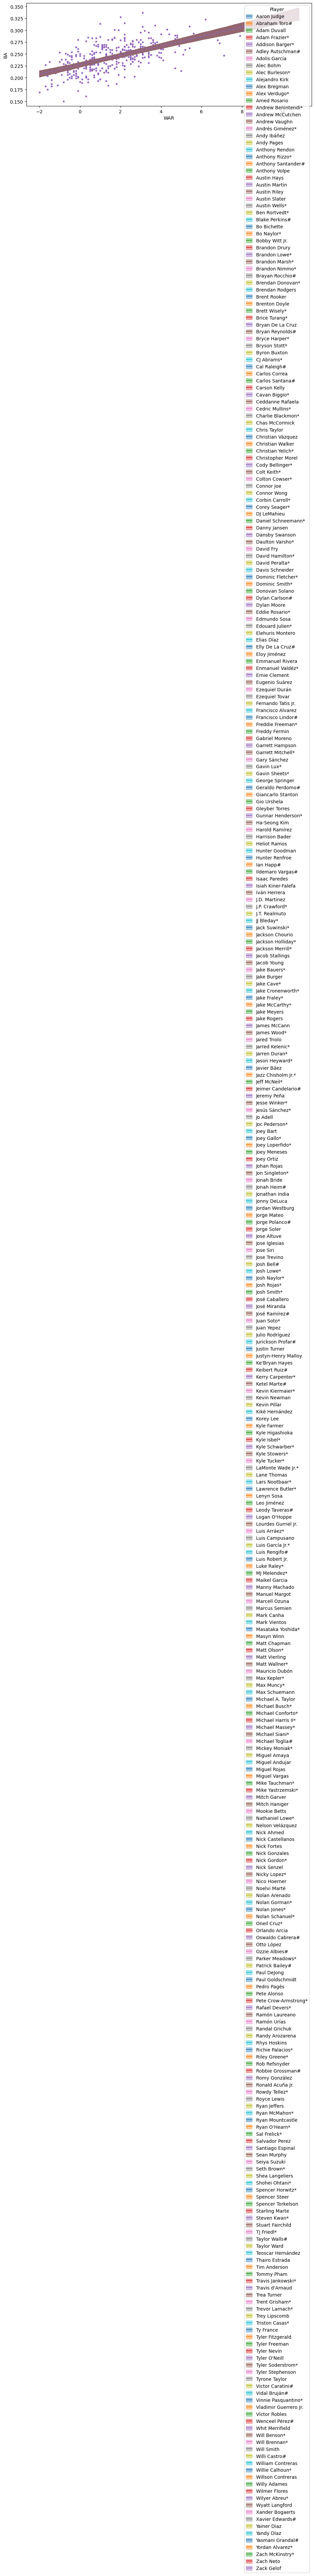

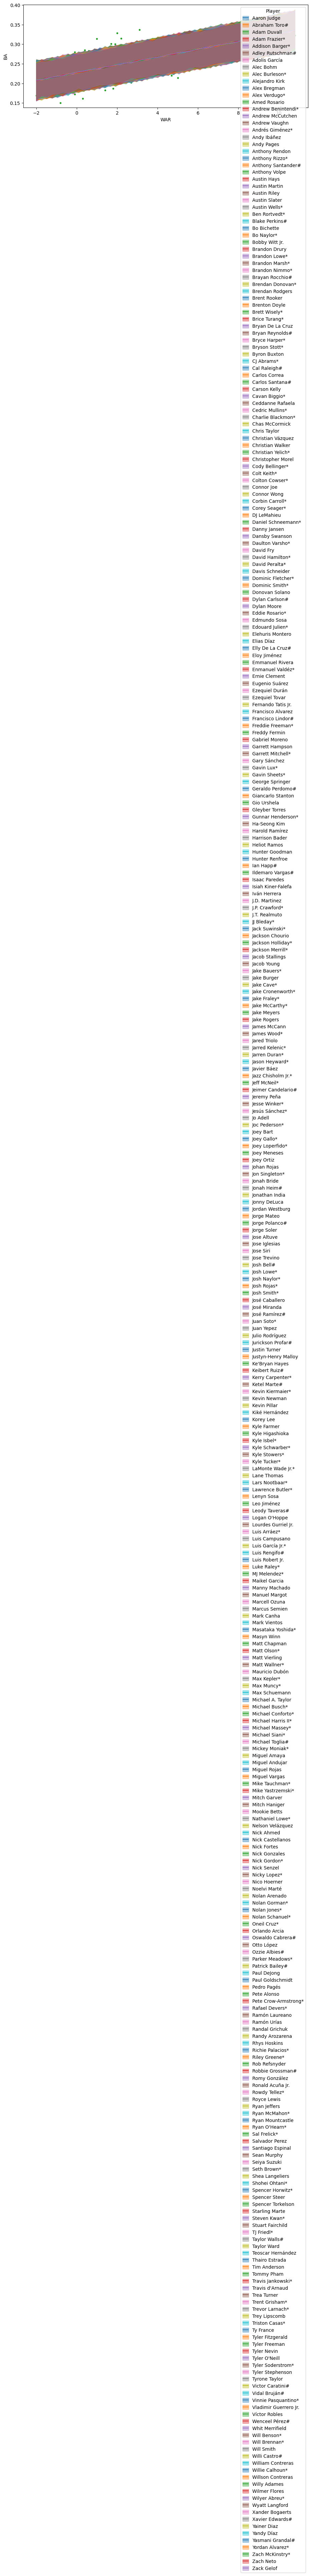

In [116]:
#define the model
model_baseball3 = bmb.Model("BA ~ WAR + Player", data=baseball)
#fit the model
idata_model_baseball3 = model_baseball.fit(idata_kwargs={'log_likelihood': True})
#checking priors
model_baseball
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["WAR", "Player"], fig_kwargs={"figsize":(11, 4)})
plt.plot(baseball.WAR, baseball.BA, "C14.", zorder=-3)

bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["WAR", "Player"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(baseball.WAR, baseball.BA, "C2.", zorder=-3)

There are so many players, but every point is sucessfully covered, im not sure why it goes into the negatives for players like ALex Verdugo. Ok now i will compare Batting average, WAR, and home runs. This means were taking Postiiton and player out of the model

In [30]:
model_HR_WAR = bmb.Model("`BA` ~ `WAR` + `HR` + `WAR`:`HR`", data=baseball)
idata_HR_WAR = model_HR_WAR.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [31]:
bmb.interpret.plot_predictions(model_HR_WAR,
                               idata_HR_WAR,
                               ["WAR","HR"],
                               fig_kwargs={"figsize":(11, 13)})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x1300 with 1 Axes>,
 array([<Axes: xlabel='WAR', ylabel='BA'>], dtype=object))

I expected for there to be an upward trend, as Ba increases so does WAR ok now im going to compare these three models with elpd_loo to see which ones elpd_loo thinks are stronger.

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

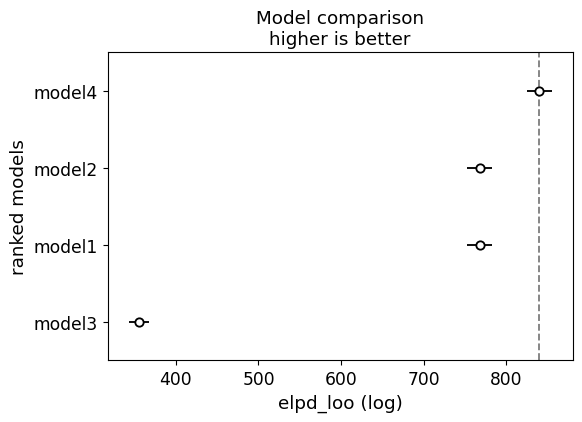

In [44]:
loo_1 = az.loo(model_baseball1)
loo_2 = az.loo(model_baseball2)
loo_3 = az.loo(model_baseball3)
loo_4 = az.loo(idata_HR_WAR)

cmp_df = az.compare( {"model1":model_baseball1, "model2":model_baseball2, "model3":model_baseball3, "model4":idata_HR_WAR} )
cmp_df
az.plot_compare(cmp_df)

ok so model 4 or idata_HR_WAR is the strongest, i kind of expected this because this model doesnt rely so much on postition or player. One thing about baseball is its not like basketball or soccer where each player has a concrete postion, its much more fluid so positions that were defined by me or someone else may be different than what is really reflected on the field. Before i close this im going to see if OBP and Slugging will form a better model -- im doing this becasue i know from outside knowledge that Bobby witt jr has a good OBP, SLG and overall batting average so i wonder if that is reflective across all players or if hes just a freak of nature lol. this will be tedious because i will need to include slg in my data.

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


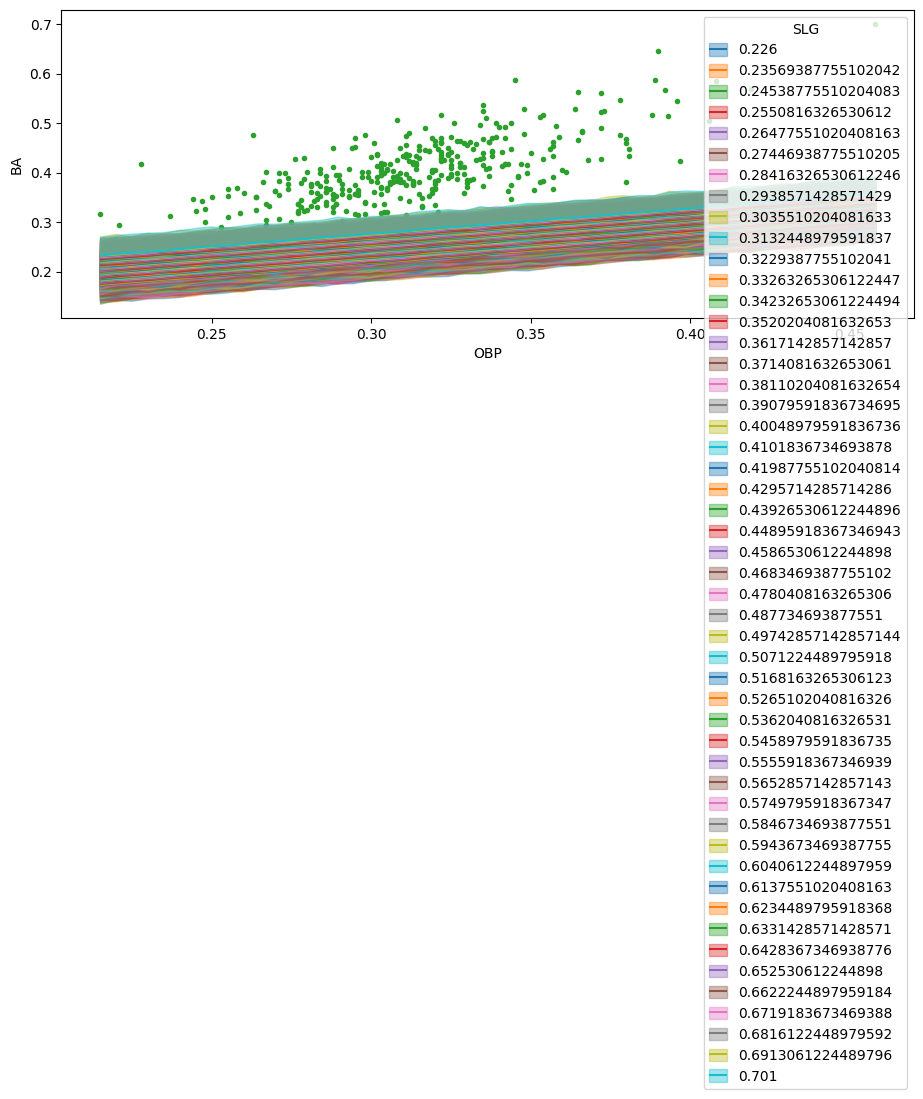

In [120]:
#define the model
model_baseball4 = bmb.Model("BA ~ SLG + OBP", data=baseball)
#fit the model
idata_model_baseball4 = model_baseball.fit(idata_kwargs={'log_likelihood': True})
#checking priors
model_baseball
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["OBP", "SLG"], fig_kwargs={"figsize":(11, 4)})
plt.plot(baseball.OBP, baseball.SLG, "C14.", zorder=-3)

bmb.interpret.plot_predictions(model_baseball, idata_model_baseball, ["OBP", "SLG"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(baseball.OBP, baseball.SLG, "C2.", zorder=-3)

ok the SLG falls way below the batting average, I dont think this is a good indicator. Im just going to compare them now.

In [121]:
loo_1 = az.loo(idata_model_baseball1)
loo_2 = az.loo(idata_model_baseball2)
loo_3 = az.loo(idata_model_baseball3)
loo_4 = az.loo(idata_HR_WAR)
loo_5 = az.loo(idata_model_baseball4)

cmp_df = az.compare( {"model1":idata_model_baseball1, "model2":idata_model_baseball2, "model3":idata_model_baseball3, "model4":idata_HR_WAR, "model5":idata_model_baseball4} )
cmp_df
az.plot_compare(cmp_df)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

model 5 is exponentially better than the rest. I think this is because SLG and OBP do have a direct effect of the outcome of the BA. Other variables such as Player or position are less indicative of the players BA -- especially on models like these, because there is no real prior knowldge on the caliber of the player or understanding of how the postiioonig works (in baseball it is very weird) so i understad why 5 works the best. yay